In [2]:

import numpy as np 
import pandas as pd 
import os

import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import pickle

PRE_PROCESSING

In [3]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        try:
            image = Image.open(img_path)
            boxes = torch.tensor(boxes)
        except:
            return

        if self.transform:
            image, boxes = self.transform(image, boxes)

            
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            
            if label_matrix[i, j, 20] == 0:
                
                label_matrix[i, j, 20] = 1

                
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

UTILS

In [4]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    
    
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    
    average_precisions = []

    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

                
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

            
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            
            
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

                    
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes,classes_list,colors_list):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    
    fig, ax = plt.subplots(1)
    ax.imshow(im)

    
    for box in boxes:
        c=box[0]
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=3,
            edgecolor=colors_list[int(c)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(upper_left_x*width,upper_left_y*height,classes_list[int(c)],color=colors_list[int(c)],fontsize=20)
    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )



            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
   

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def class_idx(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    return predicted_class

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

LOSS FUNCTION

In [5]:
class YoloLoss(nn.Module):
    

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        
        self.S = S
        self.B = B
        self.C = C

        
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3) 

        
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )


        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )


        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )


        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

YOLO ARCHITECTURE

In [6]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

Load Metrics

In [9]:
def loadMetrics():
  with open("../input/weights-100-epochs/graph_metrics_new.txt", "rb") as fp:   # Unpickling
    graph_metrics = pickle.load(fp) 
  
  epochs_completed = graph_metrics[0]
  best_val_map = graph_metrics[1]
  train_loss = graph_metrics[2]
  val_loss = graph_metrics[3]
  train_map = graph_metrics[4]
  val_map = graph_metrics[5]
  
  return epochs_completed,best_val_map,train_loss, val_loss, train_map, val_map

TRAINING

In [12]:
def collate_fn(batch):

    batch2 = []
    for b in batch:
        if not any(elem is None for elem in b):
            batch2.append(b)
    return torch.utils.data.dataloader.default_collate(batch2)


seed = 123
torch.manual_seed(seed)


LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 
WEIGHT_DECAY = 0
EPOCHS = 55
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "../input/weights-100-epochs/best_val_new.pth.tar"
IMG_DIR = "../input/pascalvoc-yolo/images"
LABEL_DIR = "../input/pascalvoc-yolo/labels"
CONTINUE_TRAINING = True
CONTINUE_MODEL_FILE = "../input/weights/checkpoint.pth.tar"

def saveMetrics(epochs_completed,best_val_map,train_loss,val_loss,train_map,val_map):
  with open("graph_metrics_new.txt", "wb") as fp:   #Pickling
    pickle.dump([epochs_completed,best_val_map,train_loss,val_loss,train_map,val_map], fp) 



class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn,do_backprop,train_loss,val_loss):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        if do_backprop:
          loss.backward()
          optimizer.step()

        loop.set_postfix(loss=loss.item())
    if do_backprop:
      train_loss.append(sum(mean_loss)/len(mean_loss))
    else:
      val_loss.append(sum(mean_loss)/len(mean_loss))
    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    epochs_completed = 0
    best_val_map = 0.1
    train_loss = []
    val_loss = []
    train_map = []
    val_map = []
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    print("1")
    if CONTINUE_TRAINING:     
        load_checkpoint(torch.load(CONTINUE_MODEL_FILE), model, optimizer)
        epochs_completed, best_val_map, train_loss, val_loss, train_map, val_map = loadMetrics()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "../input/pascalvoc-yolo/train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )
    
    test_dataset = VOCDataset(
        "../input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )


    validation_dataset = VOCDataset(
        "../input/validationscsv/validation.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )
    print(len(validation_dataset))
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn
    )

    validation_loader = DataLoader(
        dataset=validation_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn
    )

    for epoch in range(EPOCHS):
        if CONTINUE_TRAINING == True:
          print("\n######EPOCH =",epochs_completed,"#######")
        else:
          print("\n######EPOCH =",epoch,"#######")
        
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        train_map.append(mean_avg_prec)
        print(f"Train mAP: {mean_avg_prec}")


        train_fn(train_loader, model, optimizer, loss_fn,True,train_loss,val_loss)
        epochs_completed += 1


        val_pred_boxes, val_target_boxes = get_bboxes(validation_loader, model, iou_threshold=0.5, threshold=0.4)
        val_mean_avg_prec = mean_average_precision(
            val_pred_boxes, val_target_boxes, iou_threshold=0.5, box_format="midpoint"
        )

        val_map.append(val_mean_avg_prec)
        print(f"Validation mAP: {val_mean_avg_prec}")

        if val_mean_avg_prec > best_val_map:
            best_val_map = val_mean_avg_prec
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename='best_val_new.pth.tar')
            saveMetrics(epochs_completed,best_val_map,train_loss,val_loss,train_map,val_map)

            import time
            time.sleep(10)

        if epochs_completed % 9 == 0:
            checkpoint = {
                  "state_dict": model.state_dict(),
                  "optimizer": optimizer.state_dict(),
              }
            save_checkpoint(checkpoint, filename='checkpoint_new.pth.tar')
            saveMetrics(epochs_completed,best_val_map,train_loss,val_loss,train_map,val_map)
            import time
            time.sleep(10)
        train_fn(validation_loader, model, optimizer, loss_fn,False,train_loss,val_loss)
        

# if __name__ == "__main__":
main()

1


KeyboardInterrupt: 

GENERATE PLOTS

Text(0.5, 1.0, "map's vs epochs")

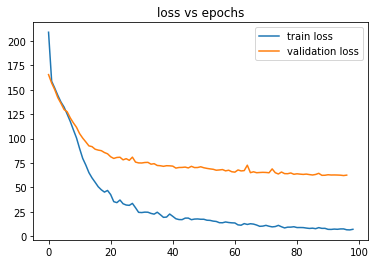

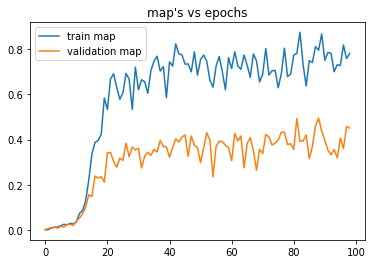

In [10]:
epochs_completed, best_val_map, train_loss, val_loss, train_map, val_map = loadMetrics()

plot1 = plt.figure(1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss", "validation loss"])
plt.title("loss vs epochs")

plot2 = plt.figure(2)
plt.plot(train_map)
plt.plot(val_map)
plt.legend(["train map", "validation map"])
plt.title("map's vs epochs")

TEST PREDICTIONS

=> Loading checkpoint
Train mAP: 0.928392767906189


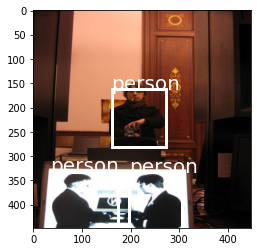

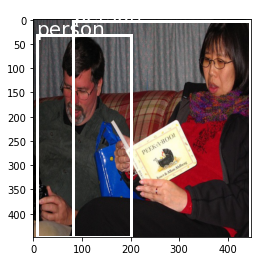

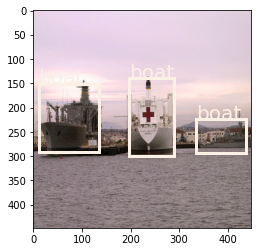

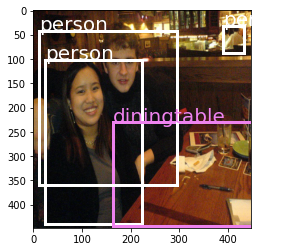

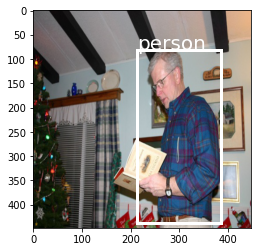

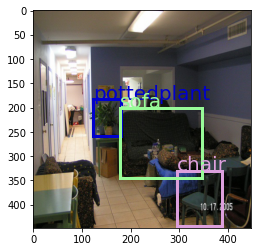

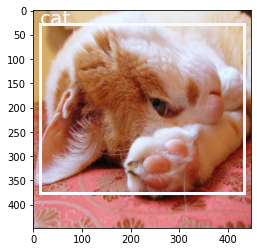

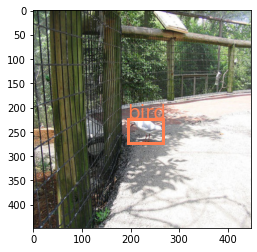

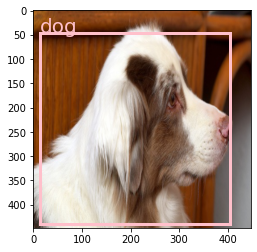

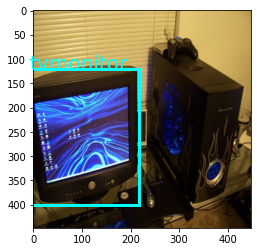

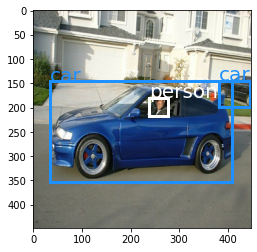

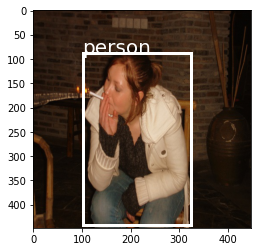

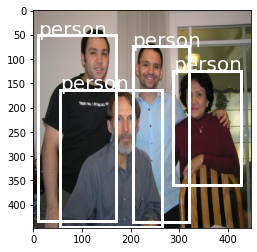

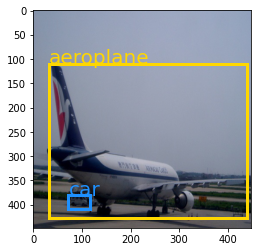

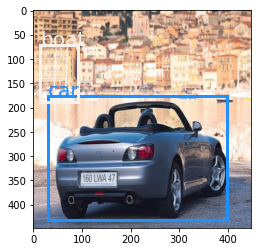

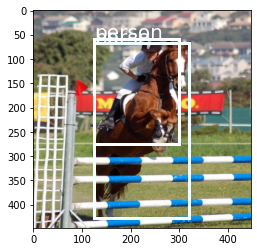

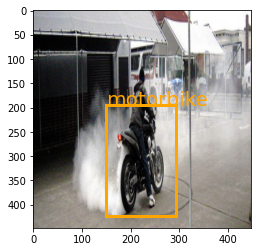

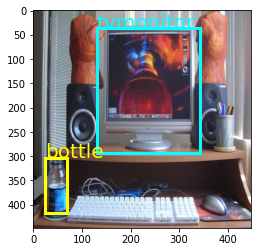

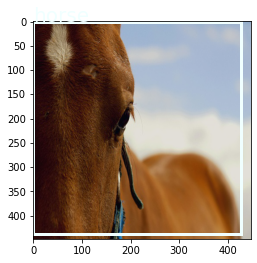

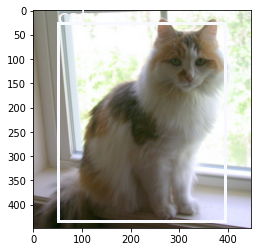

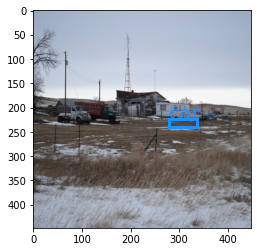

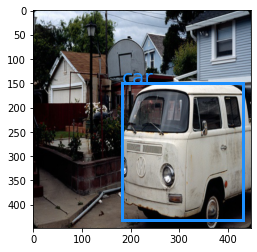

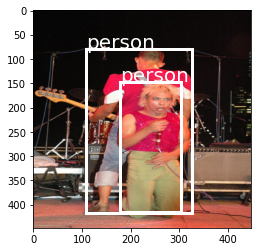

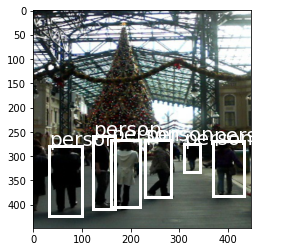

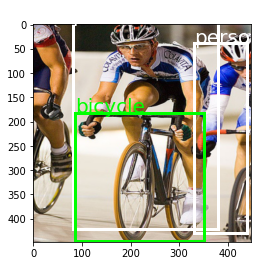

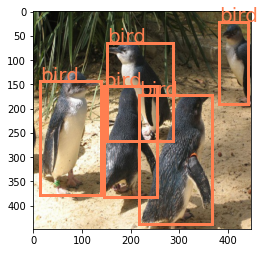

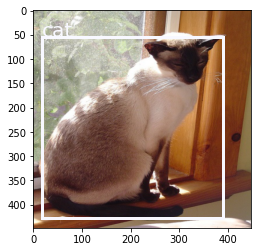

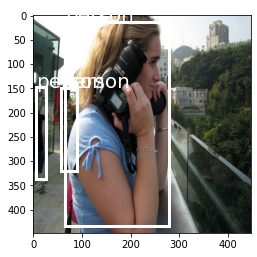

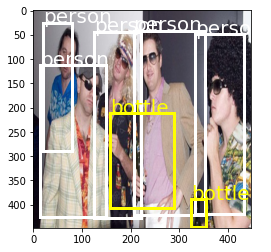

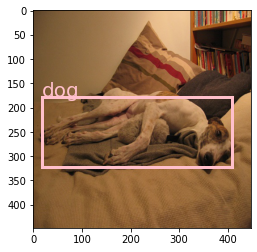

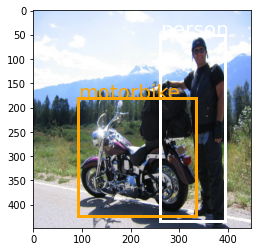

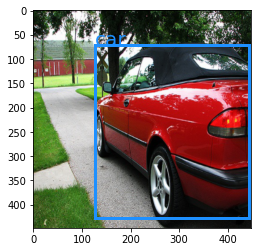

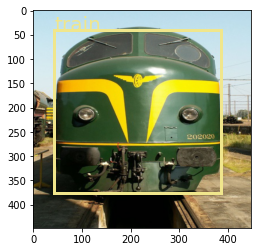

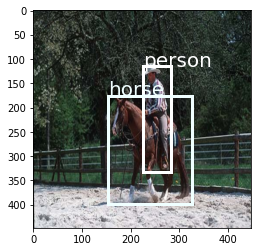

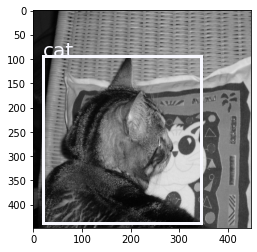

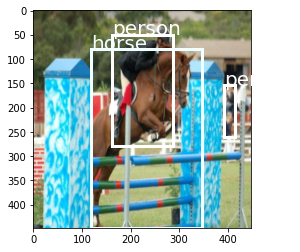

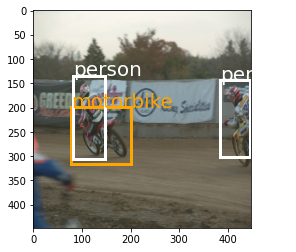

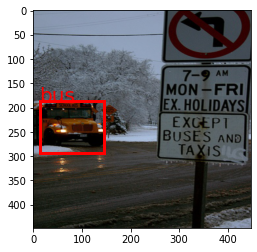

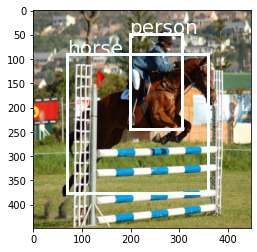

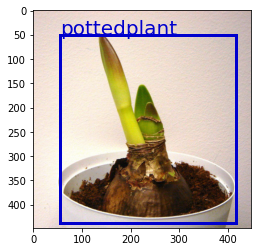

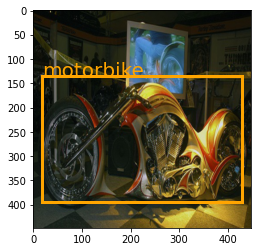

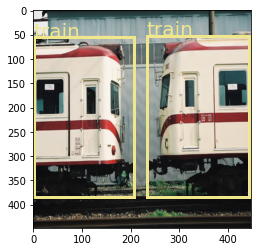

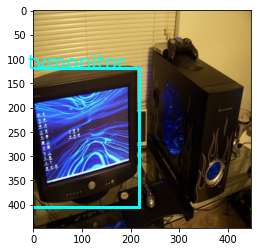

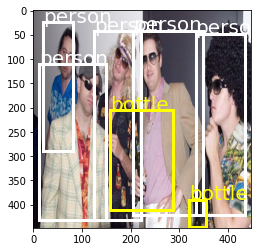

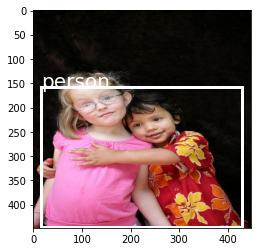

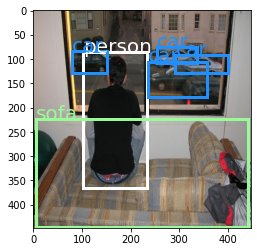

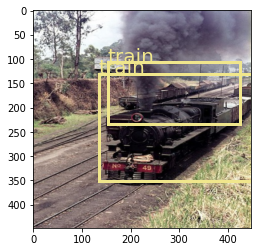

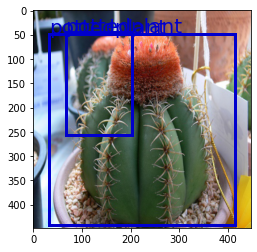

14.297837257385254


In [13]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16  
WEIGHT_DECAY = 0
EPOCHS = 8
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "../input/weights-100-epochs/best_val_new.pth.tar"
IMG_DIR = "../input/pascalvoc-yolo/images"
LABEL_DIR = "../input/pascalvoc-yolo/labels"
classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}
classes_list=[]
colors_list=["gold","lime","coral","linen","yellow","red","dodgerblue","ghostwhite","plum","lightsteelblue","violet","pink","azure","orange","white","mediumblue","lightsalmon","palegreen","khaki","cyan"]
for key,value in classes_num.items():
    classes_list.append(key)

def evaluate():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    test_dataset = VOCDataset(
        "../input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )


    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )
    
    
    pred_boxes, target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.5, threshold=0.4
        )

    mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
    print(f"Train mAP: {mean_avg_prec}")
    
    
    
    import time
    t0 = time.time()
    for x, y in test_loader:
       x = x.to(DEVICE)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    
    

           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes,classes_list,colors_list)
    t1 = time.time()
    print(t1-t0)
    
#        import sys
#        sys.exit(0)


#if __name__ == "__main__":
evaluate()